In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd


import sys
sys.path.append('./waveglow/')
sys.path.append('./waveglow/tacotron2')

from denoiser import Denoiser
import librosa
import numpy as np
import os
import glob
import json

import torch
from text import text_to_sequence, cmudict
from text.symbols import symbols
import commons
import attentions
import modules
import models
import utils


# load waveglow
#waveglow_path = './waveglow/waveglow_256channels_universal_v5.pt'
#waveglow_path = './waveglow/waveglow_9000'
#waveglow_path = '/home/sean/Downloads/waveglow_12000'
waveglow_path = '/home/sean/Downloads/waveglow_23600'
#waveglow_path = '/home/sean/src/waveglow/checkpoints/waveglow_42000'
#waveglow_path = '/home/sean/Downloads/waveglow_90400'
#waveglow_path = '/home/sean/Downloads/waveglow_27400'
#waveglow_path = '/home/sean/Downloads/waveglow_40800'

waveglow = torch.load(waveglow_path)['model']
#waveglow = waveglow.remove_weightnorm(waveglow)
_ = waveglow.cuda().eval()
from apex import amp
waveglow, _ = amp.initialize(waveglow, [], opt_level="O3") # Try if you want to boost up synthesis speed.
denoiser = Denoiser(waveglow)

/home/sean/anaconda3/envs/glow-tts/lib/python3.6/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/sean/anaconda3/envs/glow-tts/lib/python3.6/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/sean/anaconda3/envs/glow-tts/lib/python3.6/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has changed. you can retriev

Selected optimization level O3:  Pure FP16 training.
Defaults for this optimization level are:
enabled                : True
opt_level              : O3
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : False
master_weights         : False
loss_scale             : 1.0
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O3
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : False
master_weights         : False
loss_scale             : 1.0


In [2]:
model_dir = "./logs/obama/"
hps = utils.get_hparams_from_dir(model_dir)
model = models.FlowGenerator(
    len(symbols),
    out_channels=hps.data.n_mel_channels,
    **hps.model).to("cuda")

checkpoint_path = utils.latest_checkpoint_path(model_dir)
#checkpoint_path = "./logs/trump/G_360.pth"
utils.load_checkpoint(checkpoint_path, model)
model.decoder.store_inverse() # do not calcuate jacobians for fast decoding
_ = model.eval()

cmu_dict = cmudict.CMUDict(hps.data.cmudict_path)

./logs/obama/G_1845.pth
INFO:root:Loaded checkpoint './logs/obama/G_1845.pth' (iteration 1845)


In [3]:
tst_stn = "We're rounding 'em up in a very humane way, in a very nice way. And they're going to be happy because they want to be legalized. And, by the way, I know it doesn't sound nice. But not everything is nice." # Adding spaces at the beginning and the end of utterance improves quality
#tst_stn = "What I won't do is take in two hundred thousand Syrians who could be ISIS... I have been watching this migration. And I see the people. I mean, they're men. They're mostly men, and they're strong men. These are physically young, strong men. They look like prime-time soldiers. Now it's probably not true, but where are the women?... So, you ask two things. Number one, why aren't they fighting for their country? And number two, I don't want these people coming over here."
#tst_stn = "Are you a great president? Like, from the standpoint of the other side, I think I win in a landslide because of what we did. I think we’re going to have a very interesting election. I think it’s going to be very interesting. Whoever it is, I’m going to be the best candidate that they can have. I’m not going to change. I’m going to be the best candidate that they can have, because there’s nobody that loves the country as much or more than me."
#tst_stn = " Longer pauses between sentences.How about this?"
#tst_stn = " I have small hands. Really, they are so small. "
#tst_stn = " Okay, so I'm testing a new model.  What do you think? "
#tst_stn = " This new model can produce much longer sentences, and it seems to handle more difficult words better. "
#tst_stn = " Do you think people would pay money to talk to me? "
#tst_stn = " Hello, this is Donald Trump. "
tst_stn = " Am I a great President? ..... Hell yes I am. Now what can I help you with? "
#tst_stn = " Is this thing on?  Eric! Get out of here! .... This is the president. "
tst_stn = " How much money are you paying me to talk to you? "
#tst_stn = " First off, I don't care if you don't like me. So what do you want? ..."
tst_stn = " Change will not come if we wait for some other person or some other time. We are the ones we've been waiting for. We are the change that we seek. "
sequence = np.array(text_to_sequence(tst_stn, ['english_cleaners'], cmu_dict))[None, :]
print("".join([symbols[c] for c in sequence[0]]))
x_tst = torch.autograd.Variable(torch.from_numpy(sequence)).cuda().long()
x_tst_lengths = torch.tensor([x_tst.shape[1]]).cuda()

 @CH@EY1@N@JH @W@IH1@L @N@AA1@T @K@AH1@M @IH1@F @W@IY1 @W@EY1@T @F@AO1@R @S@AH1@M @AH1@DH@ER0 @P@ER1@S@AH0@N @AO1@R @S@AH1@M @AH1@DH@ER0 time. @W@IY1 @AA1@R @DH@AH0 @W@AH1@N@Z @W@IY1@V @B@IH1@N @W@EY1@T@IH0@NG for. @W@IY1 @AA1@R @DH@AH0 @CH@EY1@N@JH @DH@AE1@T @W@IY1 seek. 


In [4]:
x_tst.shape, x_tst_lengths.shape, sequence.shape

(torch.Size([1, 123]), torch.Size([1]), (1, 123))

In [15]:
import datetime

times = []
for i in range(14, 1, -1):

    batch_sequence = np.repeat(sequence[np.newaxis, 0, :], i, axis=0)
    x_tst = torch.autograd.Variable(torch.from_numpy(batch_sequence)).cuda().long()
    x_tst_lengths = torch.tensor([x_tst.shape[1]]).cuda()

    time_start = datetime.datetime.now()
    with torch.no_grad():
      #noise_scale = 0.000015
      #noise_scale = 0.9
      noise_scale = 0.667
      length_scale = 1.1
      (y_gen_tst, *r), attn_gen, *_ = model(x_tst, x_tst_lengths, gen=True, noise_scale=noise_scale, length_scale=length_scale)
      try:
        audio = waveglow.infer(y_gen_tst.half(), sigma=0.666)#.666)
      except:
        audio = waveglow.infer(y_gen_tst, sigma=.666)
    ipd.Audio(audio.data.cpu().numpy(), rate=hps.data.sampling_rate)
    time_end = datetime.datetime.now()
    time_total = time_end - time_start
    times.insert(0, time_total.total_seconds())
    print("total = " + str(time_total))
times

total = 0:00:10.249636
total = 0:00:09.651643
total = 0:00:08.931544
total = 0:00:08.338282
total = 0:00:07.613987
total = 0:00:08.900950
total = 0:00:07.870548
total = 0:00:06.914938
total = 0:00:05.936742
total = 0:00:04.953465
total = 0:00:03.969156
total = 0:00:02.885998
total = 0:00:01.937109


[1.937109,
 2.885998,
 3.969156,
 4.953465,
 5.936742,
 6.914938,
 7.870548,
 8.90095,
 7.613987,
 8.338282,
 8.931544,
 9.651643,
 10.249636]

In [17]:
times.insert(0, 0)

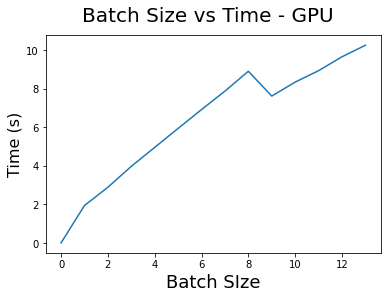

In [19]:
from matplotlib import pyplot as plt    

fig = plt.figure()
plt.plot(times)
fig.suptitle('Batch Size vs Time - GPU', fontsize=20)
plt.xlabel('Batch SIze', fontsize=18)
plt.ylabel('Time (s)', fontsize=16)
fig.savefig('test.jpg')

In [9]:
import datetime
time_start = datetime.datetime.now()
with torch.no_grad():
  #noise_scale = 0.000015
  #noise_scale = 0.9
  noise_scale = 0.667
  length_scale = 1.1
  (y_gen_tst, *r), attn_gen, *_ = model(x_tst, x_tst_lengths, gen=True, noise_scale=noise_scale, length_scale=length_scale)
  try:
    audio = waveglow.infer(y_gen_tst.half(), sigma=0.666)#.666)
  except:
    audio = waveglow.infer(y_gen_tst, sigma=.666)
ipd.Audio(audio.data.cpu().numpy(), rate=hps.data.sampling_rate)
time_end = datetime.datetime.now()
print("total = " + str(time_end - time_start))

total = 0:00:08.967608


In [7]:
audio_denoised = denoiser(audio, strength=0.01)
ipd.Audio(audio_denoised.data.cpu().numpy(), rate=hps.data.sampling_rate)